In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay


# Load the datasets
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

# Display the first few rows of each dataset
print(customers.head())
print(transactions.head())
print(engagements.head())
print(marketing.head())


   customer_id   join_date last_purchase_date   age  gender           location
0            1  2023-11-20         2024-03-17  56.0  Female  North Shannonbury
1            2  2021-09-08         2023-10-25   NaN    Male          Hillville
2            3  2021-06-01         2022-11-27   NaN     NaN   North Latoyatown
3            4  2022-01-01         2022-09-01  29.0    Male          Grossstad
4            5  2022-01-24         2023-06-02   NaN    Male   East Matthewfort
   transaction_id  customer_id transaction_date  transaction_amount  \
0               1            1       2024-02-03              165.56   
1               2            1       2024-03-02              699.01   
2               3            1       2024-03-12              146.86   
3               4            1       2024-01-20              927.46   
4               5            1       2024-02-25             1395.87   

  product_category  
0         Clothing  
1       Home Goods  
2       Home Goods  
3      Electron

In [62]:
# Convert date columns to datetime format
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

In [63]:

# Check for missing values in the customers dataset
print(customers.isnull().sum())

# Fill missing values for gender with "Unknown"
customers['gender'].fillna('Unknown', inplace=True)

# Fill missing values in the age column with "Unknown"
customers['age'] = customers['age'].fillna('Unknown')

# Display columns with missing values
print(customers[customers.isnull().any(axis=1)])

customer_id              0
join_date                0
last_purchase_date       0
age                   1009
gender                 533
location                 0
dtype: int64
Empty DataFrame
Columns: [customer_id, join_date, last_purchase_date, age, gender, location]
Index: []


/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_44193/2480634376.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['gender'].fillna('Unknown', inplace=True)


/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_44193/2023184509.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customers['age'] = pd.cut(customers['age'].replace('Unknown', -1).astype(float), bins=bins, labels=labels)


customer_id           0
join_date             0
last_purchase_date    0
age                   0
gender                0
location              0
dtype: int64


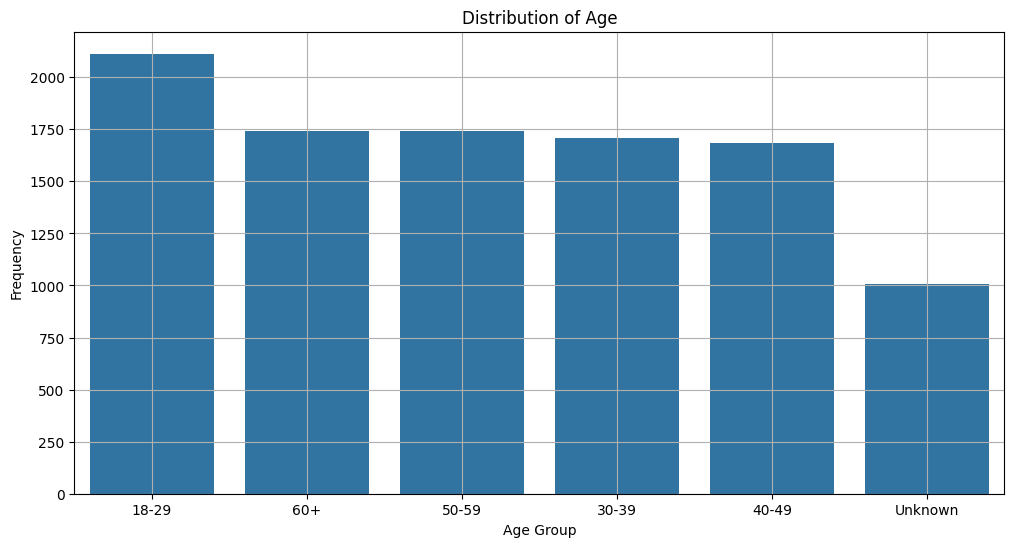

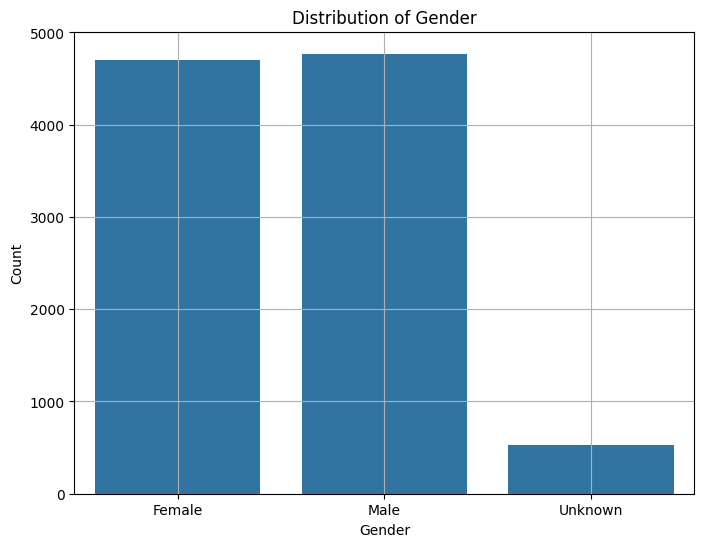

In [64]:
# Convert age into categorical ranges
bins = [0, 29, 39, 49, 59, np.inf]
labels = ['18-29', '30-39', '40-49', '50-59', '60+']
customers['age'] = pd.cut(customers['age'].replace('Unknown', -1).astype(float), bins=bins, labels=labels)
customers['age'] = customers['age'].cat.add_categories('Unknown').fillna('Unknown')

# Check if there are any remaining missing values
print(customers.isnull().sum())

# Plot the distribution of age
plt.figure(figsize=(12, 6))
sns.countplot(x='age', data=customers, order=customers['age'].value_counts().index)
plt.title('Distribution of Age')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the distribution of gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=customers)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [65]:
# Now the missing value is filled

In [66]:

# Find the latest date among all datasets
latest_date_customers = customers[['join_date', 'last_purchase_date']].max().max()
latest_date_transactions = transactions['transaction_date'].max()
latest_date_marketing = marketing['campaign_date'].max()

# Find the overall latest date
overall_latest_date = max(latest_date_customers, latest_date_transactions, latest_date_marketing)

print(f'Latest Date among all data: {overall_latest_date}')

Latest Date among all data: 2024-05-31 00:00:00


In [67]:
# So 2024-05-31 is the date we stand at

/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_44193/4136726554.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_customers['join_month'] = new_customers['join_date'].dt.to_period('M')


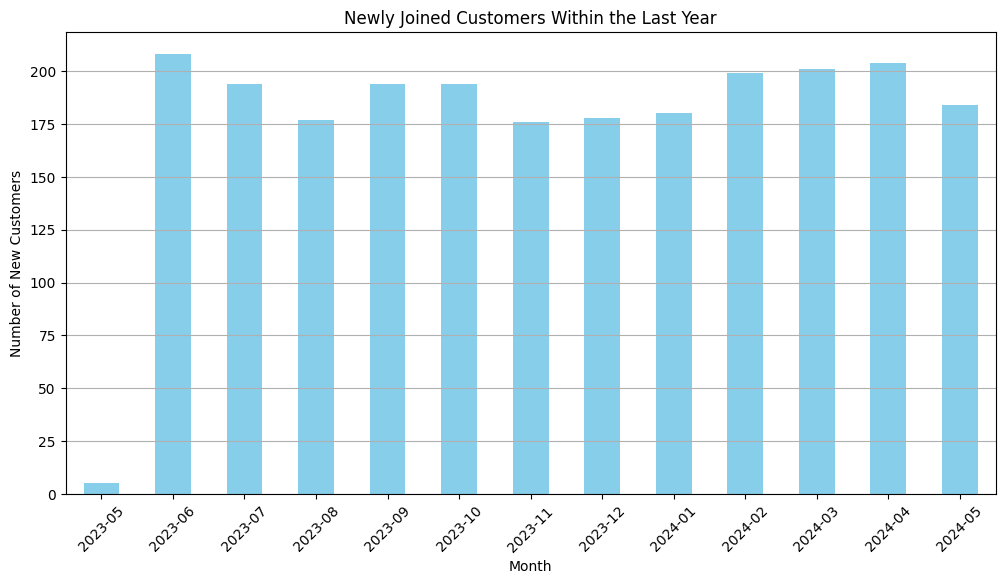

In [68]:

# Reference date
reference_date = pd.to_datetime('2024-05-31')

# Filter customers who joined within the last year
one_year_ago = reference_date - pd.DateOffset(years=1)
new_customers = customers[customers['join_date'] >= one_year_ago]

# Extract the month and year from the join_date
new_customers['join_month'] = new_customers['join_date'].dt.to_period('M')

# Count the number of customers who joined in each month
monthly_new_customers = new_customers['join_month'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(12, 6))
monthly_new_customers.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of New Customers')
plt.title('Newly Joined Customers Within the Last Year')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [39]:
# join date of new customers are almost uniformly distributed

In [73]:
# Convert age into categorical ranges
bins = [0, 29, 39, 49, 59, np.inf]
labels = ['18-29', '30-39', '40-49', '50-59', '60+']
customers['age'] = pd.cut(customers['age'].replace('Unknown', -1).astype(float), bins=bins, labels=labels)
customers['age'] = customers['age'].cat.add_categories('Unknown').fillna('Unknown')

# Filter transactions within the specified period
filtered_transactions = transactions[(transactions['transaction_date'] >= start_date) & (transactions['transaction_date'] <= end_date)]

# Filter marketing data within the specified period
filtered_marketing = marketing[(marketing['campaign_date'] >= start_date) & (marketing['campaign_date'] <= end_date)]

# Calculate total transaction amount for each customer within the specified period
customer_transaction_sums = filtered_transactions.groupby('customer_id')['transaction_amount'].sum().reset_index()
customer_transaction_sums.columns = ['customer_id', 'total_transaction_amount']



/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_44193/356806091.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  customers['age'] = pd.cut(customers['age'].replace('Unknown', -1).astype(float), bins=bins, labels=labels)


ValueError: Cannot cast object dtype to float64